In [14]:
#Primero vamos a importar todas la librerias 
import json
import requests
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
sns.set_theme(style='darkgrid')


In [2]:
#Llamamos la ruta de la api del inegi y verificamos el acceso correcto con la respuesta 200
url = requests.get('https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1006000039,4000000001,6200009438,6200009439/es/0700/true/BISE/2.0/98e2af6a-2888-9376-3b7f-29fc0bd63e65?type=json')
print(url)

<Response [200]>


In [3]:
#Catalogo de funciones
class INEGI_BI:
    def __init__(self, token):
        self.__token = token 
        self.__url_base = 'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/'
        self.__url_indicador =  self.__url_base + 'INDICATOR/'
        self._indicadores = list() 
        self._bi = list() 
        self._columnas = list() 
        self.__clave_entidad = None
    
    def __call_api_request(self, url_api):
        requests_result = requests.get(url_api, headers={"User-Agent":self.__token})
        try:
            assert requests_result.status_code == 200, 'Favor de revisar sus parametros o token asignado, ya que no se encontró información.'
            data_serie = json.loads(requests_result.text)
            return data_serie
        except requests.exceptions.Timeout:
            warnings.warn('El tiempo de consulta se ha agotado. Favor de intentar mas tarde.')
        except requests.exceptions.TooManyRedirects:
             warnings.warn('Fallo inesperado. Favor de intentar mas tarde.')
        except requests.exceptions.RequestException as e:
             warnings.warn('Error. favor de reportar a: .')
            #raise SystemExit(e)

    def __busca_bi(self, indicador):
        if len(indicador) < 10: 
            return 'BIE'
        else: 
            return 'BISE'

    def __datos_json_api(self, indicador, bi):
        bi = self.__busca_bi(indicador)
        url_api = '{}{}/es/{}/false/{}/2.0/{}?type=json'.format(self.__url_indicador, indicador,  self.__clave_entidad, bi, str(self.__token))
        datos = self.__call_api_request(url_api)
        return datos['Series'][0], bi
    
    def __json_a_df(self, datos, bi):
        serie = datos.pop('OBSERVATIONS')

        obs_totales = len(serie)
        dic = {'periodo':[serie[i]['TIME_PERIOD'] for i in range(obs_totales)],
                'valor':[float(serie[i]['OBS_VALUE']) if serie[i]['OBS_VALUE'] is not None else nan for i in range(obs_totales)]}
        df = pd.DataFrame.from_dict(dic)
        
        frecuencia = datos['FREQ']
        #factor, period = self.__frecuancias_dict[bi].get(frecuencia)
        df.set_index(df.periodo,inplace=True, drop=True)
        df = df.drop(['periodo'],axis=1)
       
        datos['BI'] = bi
        meta = pd.DataFrame.from_dict(datos, orient='index', columns=['valor'])
        return df, meta

    def __definir_cve_ent(self, entidad):
        cve_base = '0700'
        if entidad == '00': 
            self.__clave_entidad = cve_base
            return
        if len(entidad[2:5]) == 0: 
            self.__clave_entidad = '{}00{}'.format(cve_base, entidad[:2])
        else: 
            self.__clave_entidad = '{}00{}0{}'.format(cve_base, entidad[:2], entidad[2:5])
            
    def _consulta(self, inicio, fin, bi, metadatos):
        if isinstance(self._indicadores, str): self._indicadores = [self._indicadores]
        if isinstance(self._bi, str): self._bi = [self._bi]
        if isinstance(self._columnas, str): self._columnas = [self._indicadores]
        
        lista_df = list()
        meta_dfs = list()
        
        for i in range(len(self._indicadores)):
            indicador = self._indicadores[i]
            data, bi = self. __datos_json_api(indicador, bi)
            df, meta = self.__json_a_df(data, bi)
            if bi == 'BIE': 
                df = df[::-1]
            lista_df.append(df)
            meta_dfs.append(meta)
        df = pd.concat(lista_df,axis=1)
        meta = pd.concat(meta_dfs, axis=1)
    
        try: 
            df.columns = self._columnas
            meta.columns = self._columnas
        except: 
            warnings.warn('Los nombres no coinciden con el número de indicadores')
            df.columns = self._indicadores
            meta.columns = self._indicadores

        if metadatos is False: 
            return df[inicio:fin] 
        else: 
            return df[inicio:fin], meta

    def obtener_datos(self, indicadores: 'str|list', clave_area: str = '00', inicio: str = None, 
                      fin: str = None, bi: str = None, metadatos: bool = False):
        self._indicadores = indicadores
        self._columnas = indicadores
        #if nombres is not None: 
        #self._columnas = nombres
        self.__definir_cve_ent(clave_area)
        return self._consulta(inicio, fin, bi, metadatos)

    # Metadatos
    def _consultar_catalogo(self, clave, id, bi):
        url_api = '{}{}/{}/es/{}/2.0/{}/?type=json'.format(self.__url_base, clave, id, bi, self.__token)
        request_api = requests.get(url_api)
        datos = json.loads(request_api.text)
        return pd.DataFrame(datos['CODE'])

    def catalogo_indicadores(self, bi: str, indicador: str = None):
        if indicador is None: indicador = 'null'
        return self._consultar_catalogo('CL_INDICATOR', indicador, bi)

    def consulta_metadatos(self, metadatos: 'DataFrame|dict'):
        if isinstance(metadatos, dict): metadatos = pd.DataFrame.from_dict(dict)
        n_df = metadatos.copy(deep=True)
        for col in metadatos.columns:
            bi = metadatos.loc['BI',col]
            for idx in metadatos.index: 
                if idx in ['LASTUPDATE','BI']: continue
                id = metadatos.loc[idx,col]
                if id is None or len(id) == 0: continue
                if idx == 'INDICADOR': 
                    clave = 'CL_INDICATOR'
                else: 
                    clave = 'CL_{}'.format(idx)
                try:
                    desc = self._consultar_catalogo(clave, id, bi)
                    n_df.loc[idx,col] = desc.iloc[0,1]
                except: 
                    n_df.loc[idx,col] = 'La información no existe'
        return n_df
    

In [4]:
# Definir el token de API (reemplaza 'TU_TOKEN_DE_API' con tu token real)
token_api = '98e2af6a-2888-9376-3b7f-29fc0bd63e65'

# Crear una instancia de la clase INEGI_BI
inegi = INEGI_BI(token_api)

In [99]:
#Accidentes de tránsito terrestre en Ciudad de México 
TOKEN = "98e2af6a-2888-9376-3b7f-29fc0bd63e65"
API_INEGI_BI= INEGI_BI(TOKEN)
accidentes_t = API_INEGI_BI.obtener_datos(indicadores = ["1006000039","6200009438","6200009439"],clave_area = '09', inicio = '2016', fin = '2022')
display(accidentes_t)

,1006000039,6200009438,6200009439
periodo,,,
2016,11449.0,227.0,2825.0
2017,12321.0,203.0,2381.0
2018,11656.0,240.0,2637.0
2019,10673.0,226.0,2868.0
2020,6549.0,150.0,1603.0
2021,6743.0,171.0,1849.0
2022,7596.0,255.0,2127.0


In [98]:
#Muertes por accidentes de transito
Muertos = API_INEGI_BI.obtener_datos(indicadores = ["6200009438"],clave_area = '09', inicio = '2016', fin = '2022')
display(Muertos)

,6200009438
periodo,
2016,227.0
2017,203.0
2018,240.0
2019,226.0
2020,150.0
2021,171.0
2022,255.0


In [97]:
#Heridos por accidentes de transito
Heridos = API_INEGI_BI.obtener_datos(indicadores = ["6200009439"],clave_area = '09', inicio = '2016', fin = '2022')
display(Heridos)

,6200009439
periodo,
2016,2825.0
2017,2381.0
2018,2637.0
2019,2868.0
2020,1603.0
2021,1849.0
2022,2127.0


In [96]:
#Accidentes de transito en la Cdmx
Accidentes = API_INEGI_BI.obtener_datos(indicadores = ["1006000039"],clave_area = '09', inicio = '2016', fin = '2022')
display(Accidentes)

,1006000039
periodo,
2016,11449.0
2017,12321.0
2018,11656.0
2019,10673.0
2020,6549.0
2021,6743.0
2022,7596.0


In [123]:
#Número de accidentes en la Cdmx en periodo de pandemia
Accidentes_pand = API_INEGI_BI.obtener_datos(indicadores = ["1006000039"],clave_area = '09', inicio = '2019', fin = '2022')
display(Accidentes_pand)

,1006000039
periodo,
2019,10673.0
2020,6549.0
2021,6743.0
2022,7596.0


In [104]:
#Metadatos correspondientes a los: "Accidentes totales", "Muertes derivadas de accidentes" "Heridos derivados de accidentes"
datos, metadatos_claves = API_INEGI_BI.obtener_datos(indicadores = ["1006000039","6200009438","6200009439"],
#Ubicados en la Cdmx
clave_area = '09',
#En un periodo previo, durante y posterior a la pandemia covid 19
inicio = '2016', 
fin = '2021',
metadatos = True)
display(datos)

,1006000039,6200009438,6200009439
periodo,,,
2016,11449.0,227.0,2825.0
2017,12321.0,203.0,2381.0
2018,11656.0,240.0,2637.0
2019,10673.0,226.0,2868.0
2020,6549.0,150.0,1603.0
2021,6743.0,171.0,1849.0


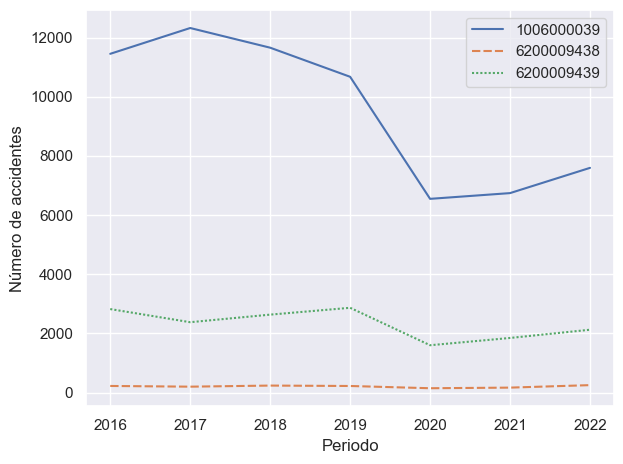

In [106]:
# Configurar el estilo de Seaborn como el estilo por defecto
sns.set()

# Crear la figura y plotear los datos utilizando Seaborn
plt.figure()
sns.lineplot( data=accidentes_t)
plt.xlabel('Periodo')
plt.ylabel('Número de accidentes')
#Ajustar layout
plt.tight_layout()
# Mostrar la gráfica
plt.show()


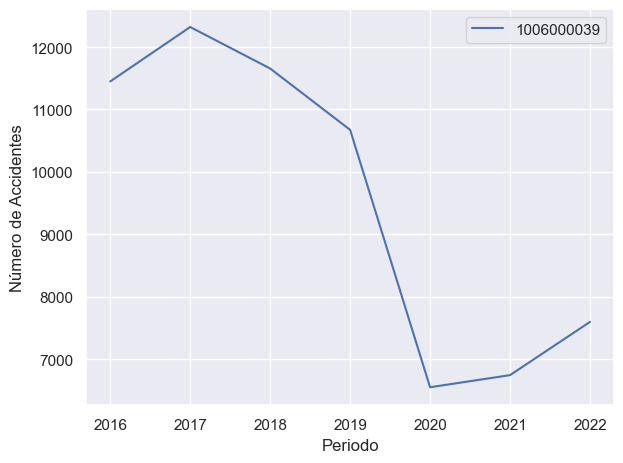

In [108]:
#Accidentes de transito en la Cdmx
plt.figure()
sns.lineplot(data=Accidentes)
plt.xlabel('Periodo')
plt.ylabel('Número de Accidentes')
plt.tight_layout()
plt.show()

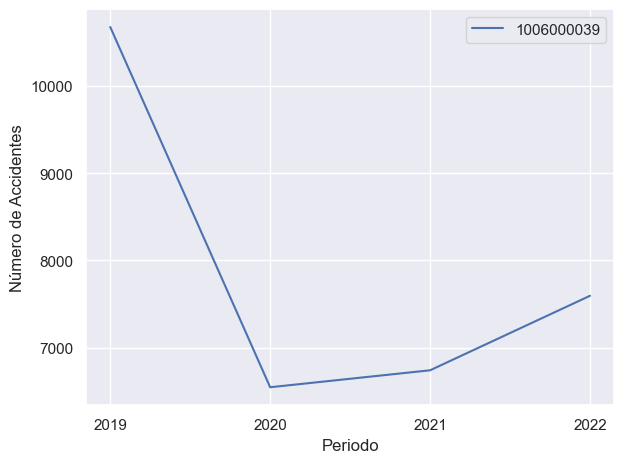

In [109]:
#Número de accidentes por año dentro del periodo de pandemia en la cdmx
plt.figure()
sns.lineplot(data=Accidentes_pand)
plt.xlabel('Periodo')
plt.ylabel('Número de Accidentes')
plt.tight_layout()
plt.show()

In [110]:
#Promedio(mean), moda(max) y mediana(50%)
Accidentes_pand.describe()

,1006000039
count,4.000000
mean,7890.250000
std,1910.097271
min,6549.000000
25%,6694.500000
50%,7169.500000
75%,8365.250000
max,10673.000000


In [113]:
#Accidentes de tránsito terrestre en Cdmx por mes durante el periodo de pandemia global Covid 19
TOKEN = "98e2af6a-2888-9376-3b7f-29fc0bd63e65"
API_INEGI_BI= INEGI_BI(TOKEN)
accidentes_mes = API_INEGI_BI.obtener_datos(indicadores = ["4000000001"], inicio = '2020', fin = '2021')
display(accidentes_mes)

,4000000001
periodo,
2020/01,30121.0
2020/02,30554.0
2020/03,27403.0
2020/04,17200.0
2020/05,19074.0
2020/06,21392.0
2020/07,23505.0
2020/08,25217.0
2020/09,24644.0


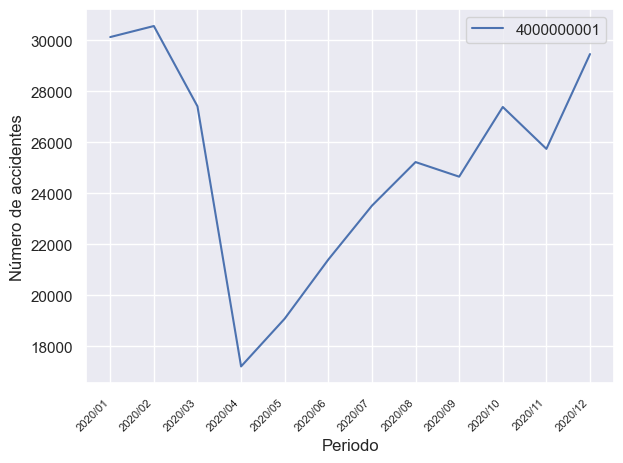

In [122]:
#Tasa de accidentes por mes durante el periodo de pandemia covid 19
plt.figure()
sns.lineplot(data=accidentes_mes)
plt.xlabel('Periodo')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel('Número de accidentes')
plt.tight_layout()
plt.show()

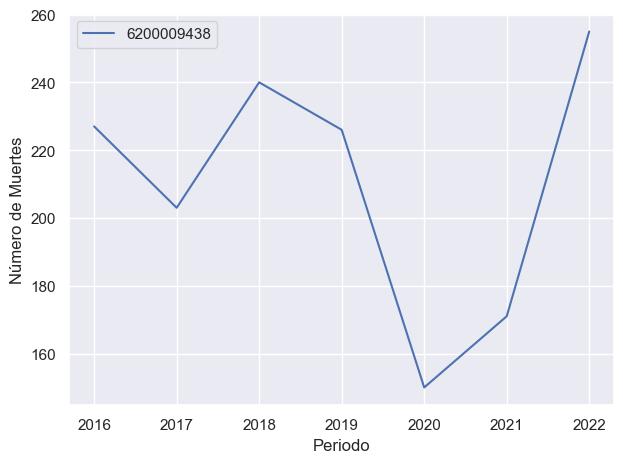

In [124]:
#Grafico con el número de muertes derivadas de accidentes de transito
plt.figure()
sns.lineplot(data=Muertos)
plt.xlabel('Periodo')
plt.ylabel('Número de Muertes')
plt.tight_layout()
plt.show()
